### Instructions
This notebook was created to collect all of the code written for the project in a linear fashion. Not hower that during the development, we used regular `.py` files for the training, which were run through terminals.
This notebook was simply made to make the code more readable. 

***Note 1: This notebook assumes that you have read the paper related to the project. Thus explainations to some of the code in this notebook will be sparse***

***Note 2: In order to run this notebook, files have to be placed in the folder `dataset/raw_color_data`. The files have to be named `{index}-{filename}` where index will be used as the identifier later on in the notebook. Furthermore, filename may not contain dashes (-). See `dataprep.py` for inspiration on how we moved files.***

### Setup

This file assumes a `unix` os. The required dependencies are listed in the `requirements.txt` file. We also recommend creating `venv` environment.
This can be installed using:

In [2]:
!source venv/bin/activate
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Standard libraries
import os
import sys
import datetime
import logging
import subprocess
import time
import glob

# Numerical processing and data visualization
import numpy as np
import matplotlib.pyplot as plt

# Deep learning frameworks
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.models import VGG16_Weights
from tensorflow.keras import backend as K

# Image processing libraries
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

# Data loading and preprocessing
from torch.utils.data import Dataset, DataLoader, random_split
from itertools import chain
from colorization.dataloader import ColorDataset

# Colorization modules
from colorization.colorizers.eccv16_siggraph.execute import eccv16_colorize, siggraph17_colorize
from colorization.colorizers.ICT.execute import ICT_colorize 
from colorization.models import EnsembleHeadColorizer

# Loss functions and metrics
from loss_functions import PerceptualLoss
from piq import ssim, psnr

# Miscellaneous
import gdown


### Global variables

In [4]:
raw_path = "./dataset/raw_color_data"
bw_path = "./dataset/bw_data"
gt_path = "./dataset/ground_truth"
pred_path = "./dataset/pred_data"
target_size = (256, 256)

#### Configuration

In [5]:
logging.basicConfig(
    format="[%(asctime)s] - %(message)s", datefmt="%H:%M:%S", level=logging.INFO
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

[21:05:33] - Using device: cuda


### Step 1: Download models and create dataset

**Note: you will need to dowload the dataset and place it in the directory `dataset/raw_color_data` manually!**\
Link to the dataset: https://www.vision.caltech.edu/datasets/cub_200_2011/\
(We have included a couple of images to be able to run this file)

In [6]:
def log(message):
    current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"[{current_time}] {message}")

def make_image_dirs():
    log("Creating directories")
    os.makedirs(raw_path, exist_ok=True)
    os.makedirs(bw_path, exist_ok=True)
    os.makedirs(gt_path, exist_ok=True)
    os.makedirs(pred_path, exist_ok=True)
    os.makedirs(f"{pred_path}/coltran", exist_ok=True)
    os.makedirs(f"{pred_path}/ICT", exist_ok=True)
    os.makedirs(f"{pred_path}/siggraph", exist_ok=True)
    os.makedirs(f"{pred_path}/eccv16", exist_ok=True)

def prep_resized_bw_data(source_path):
    for filename in os.listdir(source_path):
        f = os.path.join(source_path, filename)
        img = Image.open(f)
        img = img.resize(target_size)
        img.save(f"{gt_path}/{filename}")
        img = img.convert("L")
        img.save(f"{bw_path}/{filename}")

def process_eccv16_colorize(source_path):
    log("Colorizing using: eccv16")
    for filename in os.listdir(source_path):
        eccv16_colorize(source_path, f"{pred_path}/eccv16/", filename)
    log("eccv16 complete!")
        
def process_siggraph17_colorize(source_path):
    log("Colorizing using: siggraph17")
    for filename in os.listdir(source_path):
        siggraph17_colorize(source_path, f"{pred_path}/siggraph/", filename)
    log("siggraph17 complete!")
        
def process_ICT_colorize(source_path):
    log("Colorizing using: ICT")
    ICT_colorize(source_path, f"{pred_path}/ICT", "colorization/colorizers/ICT")
    log("ICT complete!")

def process_coltran_colorize(source_path, cleanup_files=False):
    coltran_source_dir = "colorization/colorizers/coltran/out/final/*.jpg"
    coltran_dest_dir = f"{pred_path}/coltran"

    colorize_command_step_1 = f"./pre_colorize_helpers.sh coltran_step_1 {source_path}"
    color_upsample_command_step_2 = f"./pre_colorize_helpers.sh coltran_step_2 {source_path}"
    spatial_upsample_command_step_3 = f"./pre_colorize_helpers.sh coltran_step_3 {source_path}"

    move_final_colorized_images_command = f"mv {coltran_source_dir} {coltran_dest_dir}"
    remove_out_command = ["rm", "-r", "colorization/colorizers/coltran/out/"]

    # Exectution
    log("Colorizing using: coltran")
    
    log("Step 1: Colorizer")
    subprocess.run(colorize_command_step_1, check=True, executable="/bin/bash", shell=True)
    K.clear_session()

    log("Step 2: Color upsampler")
    subprocess.run(color_upsample_command_step_2, check=True, executable="/bin/bash", shell=True)
    K.clear_session()
    
    log("Step 3: Spatial upsampler")
    subprocess.run(spatial_upsample_command_step_3, check=True, executable="/bin/bash", shell=True)
    K.clear_session()

    log("Step 4: Moving final colorized images")
    subprocess.run(move_final_colorized_images_command, shell=True, check=True, executable="/bin/bash")

    if cleanup_files:
        log("Step 5: Removing files in out/...")
        subprocess.run(remove_out_command, check=True)


def download_from_gdrive():
    weights_ICT_path = "./colorization/colorizers/ICT/final_model_weights.pt"
    weights_ICT_link = "https://drive.google.com/uc?id=1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV"

    log("Downloading weights for ICT")
    if not os.path.exists(weights_ICT_path):
        gdown.download(weights_ICT_link, weights_ICT_path, quiet=False)
    else:
        print(f"Weights for ICT already exists at {weights_ICT_path}. Skipping download.")

    weights_coltran_path = "./colorization/colorizers/coltran/weights"
    coltran_intermediate_folder = "./coltran_tmp"

    coltran_fetch_command = ["wget", "https://storage.googleapis.com/gresearch/coltran/coltran.zip", "-P", coltran_intermediate_folder]
    coltran_unzip_command = ["unzip",  f"{coltran_intermediate_folder}/coltran.zip", "-d", coltran_intermediate_folder]
    coltran_chmod_command = ["chmod", "-R", "700", f"./{coltran_intermediate_folder}/coltran"]
    coltran_move_command = ["mv", f"{coltran_intermediate_folder}/coltran", weights_coltran_path]
    coltran_remove_temp_command = ["rm", "-frd", coltran_intermediate_folder]

    log("Downloading weights for coltran")
    if not os.path.exists(weights_coltran_path):
        subprocess.run(coltran_fetch_command, check=True)
        subprocess.run(coltran_unzip_command, check=True)
        subprocess.run(coltran_chmod_command, check=True)
        subprocess.run(coltran_move_command, check=True)
        subprocess.run(coltran_remove_temp_command, check=True)
    else:
        print(f"Weights for coltran already exists at {weights_coltran_path}. Skipping download.")
    log("Weights for eccv16 and siggraph are downloaded when the model is instantiated.")


### Data prep

#### Structure
We begin by ensuring that the folder structure for the dataset is in place. If it is not, we create it.

In [7]:
make_image_dirs()

[2023-10-22 21:05:50] Creating directories


#### Weights
We then download weights for Coltran and the GAN project (named ICT in this project). Weights for ECCV and Siggraph are downloaded automatically.

In [8]:
download_from_gdrive()

[2023-10-22 21:05:54] Downloading weights for ICT
Weights for ICT already exists at ./colorization/colorizers/ICT/final_model_weights.pt. Skipping download.
[2023-10-22 21:05:54] Downloading weights for coltran
Weights for coltran already exists at ./colorization/colorizers/coltran/weights. Skipping download.
[2023-10-22 21:05:54] Weights for eccv16 and siggraph are downloaded when the model is instantiated.


### Colorization using the component models
In the following four code snippets, we colorize images using Coltran, ECCV, Siggraph and ICT 

In [ ]:
process_siggraph17_colorize(bw_path)

In [ ]:
process_eccv16_colorize(bw_path)

In [ ]:
process_ICT_colorize(bw_path)

In [ ]:
process_coltran_colorize(bw_path)

### Step 2: Model

The first model created is a simple model that averages the input channels from the ensemble.

In [9]:
class MeanChannelColorizer():
    def forward(self, x):
        # Input x: torch.Size([16, 12, 256, 256])
        # Output res: torch.Size([16, 3, 256, 256])
        # Split the tensor by colors
        reds = x[[0, 3, 6, 9], :, :]
        greens = x[[1, 4, 7, 10], :, :]
        blues = x[[2, 5, 8, 11], :, :]

        avg_reds = reds.mean(dim=0, keepdim=True)
        avg_greens = greens.mean(dim=0, keepdim=True)
        avg_blues = blues.mean(dim=0, keepdim=True)

        return torch.cat([avg_reds, avg_greens, avg_blues], dim=0)

The second model created is a CNN based head for the ensamble. 

In [10]:
class EnsembleHeadColorizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
        )
    
    def forward(self, x):
        res = self.layers(x)
        # Input x: torch.Size([16, 12, 256, 256])
        # Output res: torch.Size([16, 3, 256, 256])
        return res


### Step 3: Dataloaders
In order to efficiently handle the data in training and prediciton, we define a dataloader class. Provided an index this dataloader will load four predicted images for each of the component models, as well as the ground truth image for the index.

In [11]:
class ColorDataset(Dataset):
    def __init__(self, dataset_folder):
        self.transforms = transforms.Resize(target_size)
        # verify_dataset()
        self.image_names = [path.split("/")[-1] for path in glob.glob(f"{dataset_folder}/ground_truth/*.jpg")]
        self.image_names.sort()
        
        self.coltran_path = f"{dataset_folder}/pred_data/coltran"
        self.ICT_path = f"{dataset_folder}/pred_data/ICT"
        self.eccv16_path = f"{dataset_folder}/pred_data/eccv16"
        self.siggraph_path = f"{dataset_folder}/pred_data/siggraph"
        self.ground_truth_path = f"{dataset_folder}/ground_truth"

    def __getitem__(self, idx):
        file_name = self.image_names[idx]
        
        eccv16_tensor = self._retrieve_image(f"{self.eccv16_path}/{file_name}")
        siggraph_tensor = self._retrieve_image(f"{self.siggraph_path}/{file_name}")
        ICT_tensor = self._retrieve_image(f"{self.ICT_path}/{file_name}")
        coltran_tensor = self._retrieve_image(f"{self.coltran_path}/{file_name}")

        input_data = torch.cat((eccv16_tensor, siggraph_tensor, ICT_tensor, coltran_tensor), axis=0)
        true_data = self._retrieve_image(f"{self.ground_truth_path}/{file_name}")

        # Shape of input_data: torch.Size([12, 256, 256])
        # Shape of true_data: torch.Size([3, 256, 256])
        return input_data, true_data

    def __len__(self):
        return len(self.image_names)

    def _retrieve_image(self, img_path):
        img = Image.open(img_path)
        rgb_img = img.convert("RGB")
        npa_img = np.array(rgb_img)
        lab_img = rgb2lab(npa_img).astype("float32")
        lab_img_transposed = lab_img.transpose((2, 0, 1))
        return torch.Tensor(lab_img_transposed)

### Step 4: Loss function
Next step is to define the loss function used in training.

In [12]:
class PerceptualLoss(nn.Module):
    def __init__(self, device):
        super(PerceptualLoss, self).__init__()
        self.device = device

        self.vgg = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT).features
        for param in self.vgg.parameters():
            param.requires_grad = False

        self.vgg.eval()
        self.vgg.to(self.device)

    def forward(self, x, y):
        pred_features = self.vgg(x)
        real_features = self.vgg(y)

        vgg_mse_l = mse_loss(pred_features, real_features)
        mse_l = mse_loss(x, y)
        l1_l = l1_loss(x,y)

        mse_scaling_factor = 0.2
        tot_l = vgg_mse_l + l1_l + (mse_scaling_factor * mse_l)
        return tot_l


### Step 5: Training
Here we define the full training loop used to train the model

In [18]:
def validate(model, loss_fn, val_loader, device):
    val_loss_cum, val_psnr_cum, val_ssim_cum = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for _, (x, y) in enumerate(val_loader, 1):
            input_imgs, true_img = x.to(device), y.to(device)
            pred = model.forward(input_imgs)

            batch_loss = loss_fn(pred, true_img)
            batch_psnr, batch_ssim = calc_psnr_and_ssid_for_batch(pred, true_img)

            val_loss_cum += batch_loss.item()
            val_psnr_cum += batch_psnr.item()
            val_ssim_cum += batch_ssim.item()

    return val_loss_cum / len(val_loader), val_psnr_cum / len(val_loader), val_ssim_cum / len(val_loader)

def calc_psnr_and_ssid_for_batch(pred_batch, true_batch):
    pred_batch_rgb = torch.Tensor(lab2rgb(pred_batch.detach().cpu().numpy().transpose(0, 2, 3, 1))).permute(0,3,1,2)
    true_batch_rgb = torch.Tensor(lab2rgb(true_batch.detach().cpu().numpy().transpose(0, 2, 3, 1))).permute(0,3,1,2)
    return psnr(pred_batch_rgb, true_batch_rgb, reduction='mean', data_range=255), ssim(pred_batch_rgb, true_batch_rgb, reduction='mean', data_range=255)

def train_epoch(model, optimizer, loss_fn, train_loader, device):
    model.train()
    train_loss_batches, train_psnr_batches, train_ssim_batches = [], [], []

    for batch_index, (x, y) in enumerate(train_loader, 1):
        #if batch_index % (len(train_loader) // 5) == 0:
        #   logging.info(f"Batch {batch_index}/{len(train_loader)}")
        logging.info(f"Batch {batch_index}/{len(train_loader)}")

        input_imgs, true_img = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model.forward(input_imgs)

        loss = loss_fn(pred, true_img)
        batch_psnr, batch_ssim = calc_psnr_and_ssid_for_batch(pred, true_img)

        loss.backward()
        optimizer.step()

        train_loss_batches.append(loss.item())
        train_psnr_batches.append(batch_psnr.item())
        train_ssim_batches.append(batch_ssim.item())

    return model, train_loss_batches, train_psnr_batches, train_ssim_batches


def training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, device
):
    logging.info("Starting training")

    model.to(device)
    train_losses, val_losses, train_psnr_res, val_psnr_res, train_ssim_res, val_ssim_res = [], [], [], [], [], [] 

    for epoch in range(1, num_epochs + 1):
        model, train_loss, train_psnr, train_ssim = train_epoch(model, optimizer, loss_fn, train_loader, device)
        val_loss, val_psnr, val_ssim = validate(model, loss_fn, val_loader, device)

        logging.info(
            f"Epoch {epoch}/{num_epochs}: \t"
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, \t"
            f"Val. loss: {val_loss:.3f}, "
            f"Train PSNR: {sum(train_psnr)/len(train_psnr):.3f}, \t"
            f"Val. PSNR: {val_psnr:.3f}, "
            f"Train SSIM: {sum(train_ssim)/len(train_ssim):.3f}, \t"
            f"Val. SSIM: {val_ssim:.3f}, "
        )

        train_losses.extend(train_loss)
        val_losses.append(val_loss)

        train_psnr_res.extend(train_psnr)
        val_psnr_res.append(val_psnr)

        train_ssim_res.extend(train_ssim)
        val_ssim_res.append(val_ssim)

    return model, train_losses, val_losses, train_psnr_res, val_psnr_res, train_ssim_res, val_ssim_res


And now we initiate the training.

***Note: This project only contains four image files on GitHub. This is not sufficient for training, and is just to illustrate how the training is performed.***

In [21]:
logging.info(f"Using device: {device}")

# ---------------------- Prepare data ----------------------
path_to_dataset = "dataset"
batch_size = 8
n_workers = 8
pin_memory = True
shuffle_dataloader = True
train_ratio, val_ratio = 0.8, 0.2

logging.info(f"Loading data...")
dataset = ColorDataset(path_to_dataset)
train_dataset, val_dataset = random_split(dataset, [train_ratio, val_ratio])
logging.info(f"\t train_ratio: {train_ratio} => {len(train_dataset)} images")
logging.info(f"\t val_ratio: {val_ratio} => {len(val_dataset)} images")

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=n_workers,
    pin_memory=pin_memory,
    shuffle=shuffle_dataloader,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=n_workers,
    pin_memory=pin_memory,
    shuffle=shuffle_dataloader,
)

# ---------------------- Model training ----------------------
num_epochs = 4
learning_rate = 1e-4
weight_decay = 1e-5

logging.info(f"Training model...")
model = EnsembleHeadColorizer()
optimizer = optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
loss_fn = PerceptualLoss(device)

model, train_losses, val_losses, train_psnr, val_psnr, train_ssim, val_ssim = training_loop(
    model, optimizer, loss_fn, train_dataloader, val_dataloader, num_epochs, device
)
logging.info(f"Done! Saving model...")

current_time = datetime.datetime.now().strftime("%Y-%b-%d_%Hh%Mm%Ss")
file_name = f"model_{current_time}.ckpt"
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_psnr": train_psnr,
        "val_psnr": val_psnr,
        "train_ssim": train_ssim,
        "val_ssim": val_ssim,
        "model_stats": {
            "path_to_dataset": path_to_dataset,
            "batch_size": batch_size,
            "n_workers": n_workers,
            "pin_memory": pin_memory,
            "shuffle_dataloader": shuffle_dataloader,
            "train_ratio": train_ratio,
            "num_epochs": num_epochs,
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "loss_fn": loss_fn.__class__.__name__,
            "optimizer": optimizer.__class__.__name__,
            "model": str(model)
        },
    }, file_name
)
logging.info(f"Done! Saving model: {file_name}")

[21:09:46] - Using device: cuda
[21:09:46] - Loading data...
[21:09:46] - 	 train_ratio: 0.8 => 4 images
[21:09:46] - 	 val_ratio: 0.2 => 1 images
[21:09:46] - Training model...
[21:09:48] - Starting training
[21:09:48] - Batch 1/1
[21:09:49] - Epoch 1/4: 	Train loss: 571.755, 	Val. loss: 980.061, Train PSNR: 55.659, 	Val. PSNR: 52.180, Train SSIM: 0.971, 	Val. SSIM: 0.944, 
[21:09:49] - Batch 1/1
[21:09:50] - Epoch 2/4: 	Train loss: 567.926, 	Val. loss: 975.258, Train PSNR: 55.659, 	Val. PSNR: 52.180, Train SSIM: 0.971, 	Val. SSIM: 0.944, 
[21:09:51] - Batch 1/1
[21:09:52] - Epoch 3/4: 	Train loss: 564.327, 	Val. loss: 970.655, Train PSNR: 55.659, 	Val. PSNR: 52.180, Train SSIM: 0.971, 	Val. SSIM: 0.944, 
[21:09:52] - Batch 1/1
[21:09:53] - Epoch 4/4: 	Train loss: 560.948, 	Val. loss: 966.212, Train PSNR: 55.659, 	Val. PSNR: 52.180, Train SSIM: 0.971, 	Val. SSIM: 0.944, 
[21:09:53] - Done! Saving model...
[21:09:53] - Done! Saving model: model_2023-Oct-22_21h09m53s.ckpt


#### Loading the model

In [22]:
ckpt_path = "model_2023-Oct-19_22h04m05s.ckpt"


checkpoint = torch.load(ckpt_path)
model = EnsembleHeadColorizer()
model.load_state_dict(checkpoint['model_state_dict'])

train_losses = checkpoint["train_losses"]
val_losses = checkpoint["val_losses"]
train_psnr = checkpoint["train_psnr"]
val_psnr = checkpoint["val_psnr"]
train_ssim = checkpoint["train_ssim"]
val_ssim = checkpoint["val_ssim"]


### Step 6: Evaluation
We now evaluate the model. We do so by generating plots from the training statistics

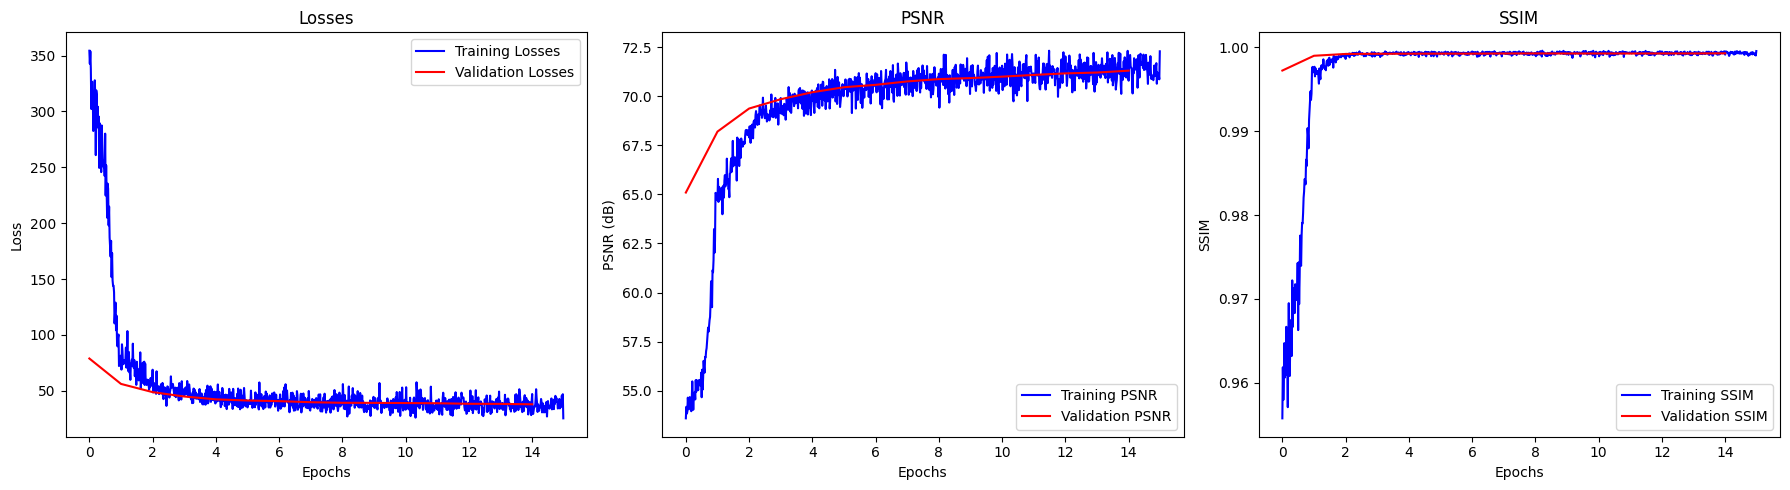

In [23]:
# Calculate the x-axis for training data
train_epochs = [i*(15/960) for i in range(960)]

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Losses plot
axes[0].plot(train_epochs, train_losses, label="Training Losses", color='blue')
axes[0].plot(range(15), val_losses, label="Validation Losses", color='red')
axes[0].set_title("Losses")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# PSNR plot
axes[1].plot(train_epochs, train_psnr, label="Training PSNR", color='blue')
axes[1].plot(range(15), val_psnr, label="Validation PSNR", color='red')
axes[1].set_title("PSNR")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("PSNR (dB)")
axes[1].legend()

# SSIM plot
axes[2].plot(train_epochs, train_ssim, label="Training SSIM", color='blue')
axes[2].plot(range(15), val_ssim, label="Validation SSIM", color='red')
axes[2].set_title("SSIM")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("SSIM")
axes[2].legend()

plt.tight_layout()
plt.show()

After evaluating the training data, we now attempt to evaluate on test data. We define a function for getting PSNR and SSIM values from the various models, including our two models.

In [24]:

def retrieve_image(img_path):
    img = Image.open(img_path)
    rgb_img = img.convert("RGB")
    npa_img = np.array(rgb_img)
    return torch.Tensor(npa_img)

def image_to_tensor(img_path):
    img = Image.open(img_path)
    rgb_img = img.convert("RGB")
    npa_img = np.array(rgb_img)
    lab_img = rgb2lab(npa_img).astype("float32")
    return transforms.ToTensor()(lab_img)

def tensor_to_image(tensor):
    npa_img = tensor.cpu().numpy().transpose((1, 2, 0))
    rgb_img = lab2rgb(npa_img).clip(0, 1)
    img = Image.fromarray((rgb_img * 255).astype(np.uint8), 'RGB')
    return img

def calculate_psnr_ssim(gt_paths, coltran_path, ICT_path, eccv16_path, siggraph_path):
    avg_model = MeanChannelColorizer()
    ens_model = EnsembleHeadColorizer()
    
    checkpoint = torch.load('model_2023-Oct-19_22h04m05s.ckpt')
    ens_model.load_state_dict(checkpoint['model_state_dict'])
    ens_model.eval()

    # Used for memory management
    def retrieve_images_in_batches(paths, amount):
        BATCH_SIZE = 100
        all_imgs = []
        for i in range(0, min(amount, len(paths)), BATCH_SIZE):
            batch_paths = paths[i:i+BATCH_SIZE]
            imgs = torch.stack([retrieve_image(p) for p in batch_paths])
            all_imgs.append(imgs)
        return torch.cat(all_imgs, dim=0)

    gt_imgs = retrieve_images_in_batches(gt_paths, 256).permute(0,3,1,2)
    coltran = retrieve_images_in_batches(coltran_path, 256).permute(0,3,1,2)
    ICT_imgs = retrieve_images_in_batches(ICT_path, 256).permute(0,3,1,2)
    eccv_imgs = retrieve_images_in_batches(eccv16_path, 256).permute(0,3,1,2)
    siggraph_imgs = retrieve_images_in_batches(siggraph_path, 256).permute(0,3,1,2)

    combined_imgs = torch.cat([eccv_imgs, siggraph_imgs, ICT_imgs, coltran], dim=1)
    averaged_imgs = torch.stack([avg_model.forward(img) for img in combined_imgs])

    averaged_imgs[0]
    
    predicted_imgs = []
    for i in range(len(coltran_path)):
        eccv16_tensor = image_to_tensor(eccv16_path[i])
        siggraph_tensor = image_to_tensor(siggraph_path[i])
        ICT_tensor = image_to_tensor(ICT_path[i])
        coltran_tensor = image_to_tensor(coltran_path[i])
        input_data = torch.cat((eccv16_tensor, siggraph_tensor, ICT_tensor, coltran_tensor), axis=0)

        ens_model.eval()
        with torch.no_grad(): 
            prediction = ens_model(input_data.unsqueeze(0)).squeeze(0)
        
        prediction = prediction.permute(1, 2, 0)

        # Convert LAB to RGB
        rgb_image = lab2rgb(prediction.cpu().numpy())

        # Convert the resulting numpy array back to a PyTorch tensor
        rgb_tensor = torch.from_numpy(rgb_image).permute(2, 0, 1).float()
        rgb_tensor = rgb_tensor * 255
        predicted_imgs.append(rgb_tensor)

    predicted_tensors = torch.stack(predicted_imgs)
    
    predicted_psnr_score = psnr(predicted_tensors, gt_imgs, reduction='mean', data_range=255), 
    predicted_ssim_score = ssim(predicted_tensors, gt_imgs, reduction='mean', data_range=255),

    combined_psnr_score = psnr(averaged_imgs, gt_imgs, reduction='mean', data_range=255), 
    combined_ssim_score = ssim(averaged_imgs, gt_imgs, reduction='mean', data_range=255),

    coltran_psnr_score = psnr(coltran, gt_imgs, reduction='mean', data_range=255), 
    coltran_ssim_score = ssim(coltran, gt_imgs, reduction='mean', data_range=255),

    ict_psnr_score = psnr(ICT_imgs, gt_imgs, reduction='mean', data_range=255), 
    ict_ssim_score = ssim(ICT_imgs, gt_imgs, reduction='mean', data_range=255),

    eccv_psnr_score = psnr(eccv_imgs, gt_imgs, reduction='mean', data_range=255), 
    eccv_ssim_score = ssim(eccv_imgs, gt_imgs, reduction='mean', data_range=255),

    siggraph_psnr_score = psnr(siggraph_imgs, gt_imgs, reduction='mean', data_range=255), 
    siggraph_ssim_score = ssim(siggraph_imgs, gt_imgs, reduction='mean', data_range=255),

    return (combined_psnr_score, combined_ssim_score, coltran_psnr_score, 
            coltran_ssim_score, ict_psnr_score, ict_ssim_score, 
            eccv_psnr_score, eccv_ssim_score, siggraph_psnr_score, 
            siggraph_ssim_score, predicted_ssim_score ,predicted_psnr_score)


Using the function we generate PSNR and SSIM data.

In [25]:

ground_truth_image_path = glob.glob(f"dataset/ground_truth/*")
coltran_image_path = glob.glob(f"dataset/pred_data/coltran/*")
ICT_image_path = glob.glob(f"dataset/pred_data/ICT/*")
eccv16_image_path = glob.glob(f"dataset/pred_data/eccv16/*")
siggraph_image_path = glob.glob(f"dataset/pred_data/siggraph/*")

assert len(ground_truth_image_path) == len(coltran_image_path) == len(ICT_image_path) == len(eccv16_image_path) == len(siggraph_image_path)

ground_truth_image_path.sort()
coltran_image_path.sort()
ICT_image_path.sort()
eccv16_image_path.sort()
siggraph_image_path.sort()
(combined_psnr_score, combined_ssim_score, coltran_psnr_score, 
    coltran_ssim_score, ict_psnr_score, ict_ssim_score, 
    eccv_psnr_score, eccv_ssim_score, siggraph_psnr_score, 
    siggraph_ssim_score, predicted_ssim_score, predicted_psnr_score) = calculate_psnr_ssim(ground_truth_image_path, coltran_image_path, ICT_image_path, eccv16_image_path, siggraph_image_path)

psnr_scores = [
    coltran_psnr_score[0].item(), ict_psnr_score[0].item(), eccv_psnr_score[0].item(),
    siggraph_psnr_score[0].item(), combined_psnr_score[0].item(), predicted_psnr_score[0].item()
]

ssim_scores = [
    coltran_ssim_score[0].item(), ict_ssim_score[0].item(), eccv_ssim_score[0].item(),
    siggraph_ssim_score[0].item(), combined_ssim_score[0].item(), predicted_ssim_score[0].item()
]

colors = ['C0', 'C0', 'C0', 'C0', 'green', 'orange']
labels = ['Coltran', 'U-Net/GAN', 'ECCV', 'Siggraph', 'Averaged', 'Ensamble']

Finally, we plot the data.

***Since this project only contains four images, we will only evaluate on four images. Please see the project paper for thurough evaluation plots.***

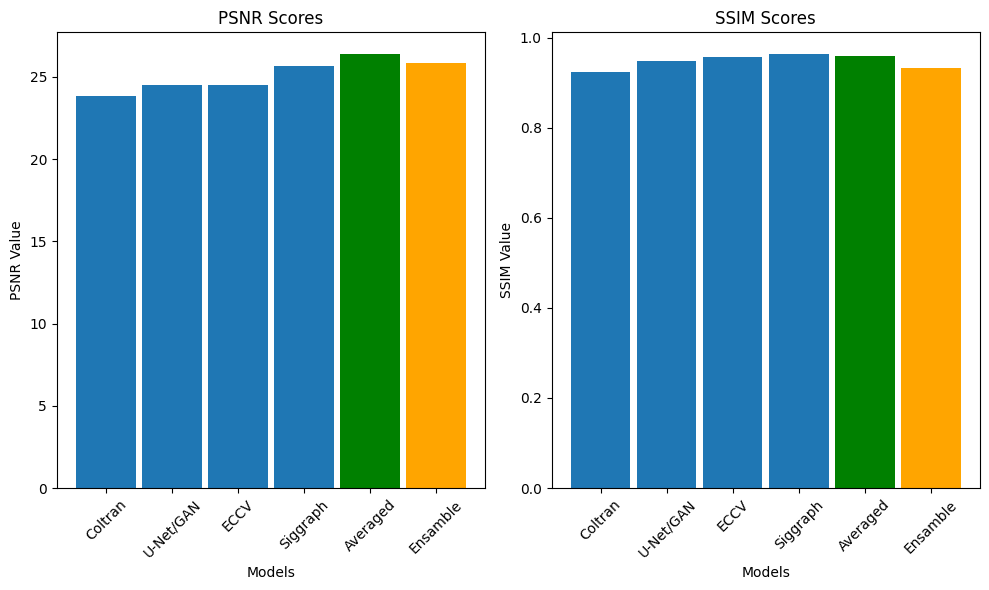

In [26]:
# Create combined plot with side-by-side subplots
plt.figure(figsize=(10, 6))

# PSNR subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.bar(labels, psnr_scores, color=colors, width=0.9)
plt.xticks(rotation=45)  # Tilt text under bars
plt.title('PSNR Scores')
plt.ylabel('PSNR Value')
plt.xlabel('Models')

# SSIM subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.bar(labels, ssim_scores, color=colors, width=0.9)
plt.xticks(rotation=45)  # Tilt text under bars
plt.title('SSIM Scores')
plt.ylabel('SSIM Value')
plt.xlabel('Models')

plt.tight_layout()
plt.savefig('combined_scores.png')
plt.show()

### Step 7: Visualizing the result
We start by defining function for visualizing images

In [29]:
def image_to_tensor(img_path):
    img = Image.open(img_path)
    rgb_img = img.convert("RGB")
    npa_img = np.array(rgb_img)
    lab_img = rgb2lab(npa_img).astype("float32")
    return transforms.ToTensor()(lab_img)

def tensor_to_image(tensor):
    npa_img = tensor.cpu().numpy().transpose((1, 2, 0))
    rgb_img = lab2rgb(npa_img).clip(0, 1)
    img = Image.fromarray((rgb_img * 255).astype(np.uint8), 'RGB')
    return img

def colorize_image(image_index, model):

    ground_truth_image_path = glob.glob(f"dataset/ground_truth/{image_index}-*")[0]
    bw_image_path = glob.glob(f"dataset/bw_data/{image_index}-*")[0]
    coltran_image_path = glob.glob(f"dataset/pred_data/coltran/{image_index}-*")[0]
    ICT_image_path = glob.glob(f"dataset/pred_data/ICT/{image_index}-*")[0]
    eccv16_image_path = glob.glob(f"dataset/pred_data/eccv16/{image_index}-*")[0]
    siggraph_image_path = glob.glob(f"dataset/pred_data/siggraph/{image_index}-*")[0]

    saved_model = model
    mean_channel_colorizer = MeanChannelColorizer()

    eccv16_tensor = image_to_tensor(eccv16_image_path)
    siggraph_tensor = image_to_tensor(siggraph_image_path)
    ICT_tensor = image_to_tensor(ICT_image_path)
    coltran_tensor = image_to_tensor(coltran_image_path)
    input_data = torch.cat((eccv16_tensor, siggraph_tensor, ICT_tensor, coltran_tensor), axis=0)

    saved_model.eval()
    with torch.no_grad(): 
        avg = mean_channel_colorizer.forward(input_data)
        prediction = saved_model.forward(input_data)
    
    predicted_colorization = tensor_to_image(prediction)
    avg_colorization = tensor_to_image(avg)
    ground_truth_colorization = Image.open(ground_truth_image_path)
    bw_colorization = Image.open(bw_image_path)
    coltran_colorization = Image.open(coltran_image_path)
    ICT_colorization = Image.open(ICT_image_path)
    eccv16_colorization = Image.open(eccv16_image_path)
    siggraph_colorization = Image.open(siggraph_image_path)

    # Setting up the images and titles
    images = [
        eccv16_colorization, 
        siggraph_colorization,
        ICT_colorization, 
        coltran_colorization,
        bw_colorization,
        ground_truth_colorization,
        avg_colorization,
        predicted_colorization
    ]

    # Create a figure with 2x4 subplots
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    # Flatten axes for easy indexing
    axes = axes.flatten()

    # Titles for each subplot
    titles = [
        "ECCV16", "Siggraph", "U-Net/GAN", "Coltran",
        "Grayscale", "Ground Truth", "Average", "Ensamble"
    ]

    # Display each image in a subplot
    for ax, img, title in zip(axes, images, titles):
        if title == "Grayscale":
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    # Show the entire figure
    plt.tight_layout()
    plt.show()

We then call the funciton to colorize the images.

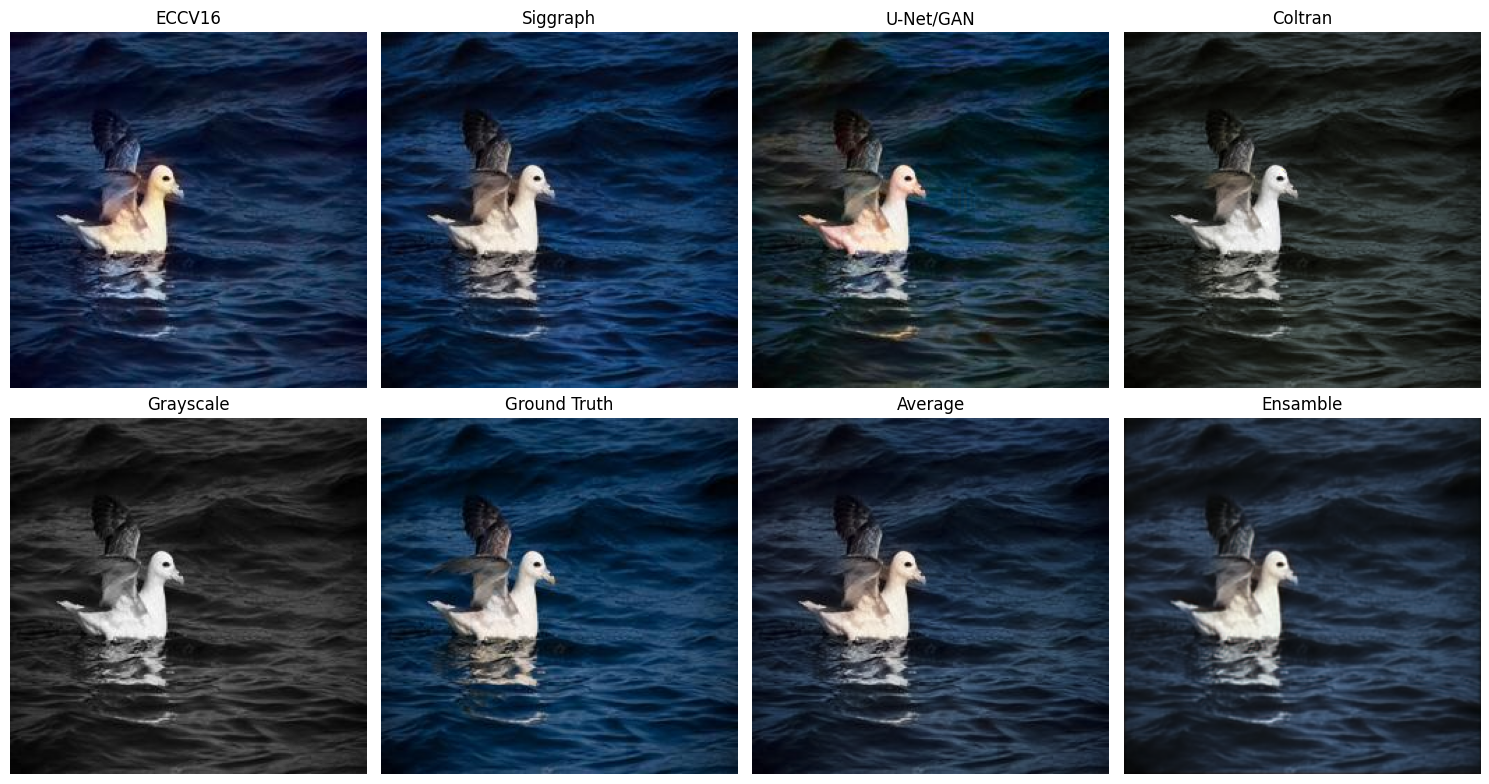

In [32]:
colorize_image(2560, model)

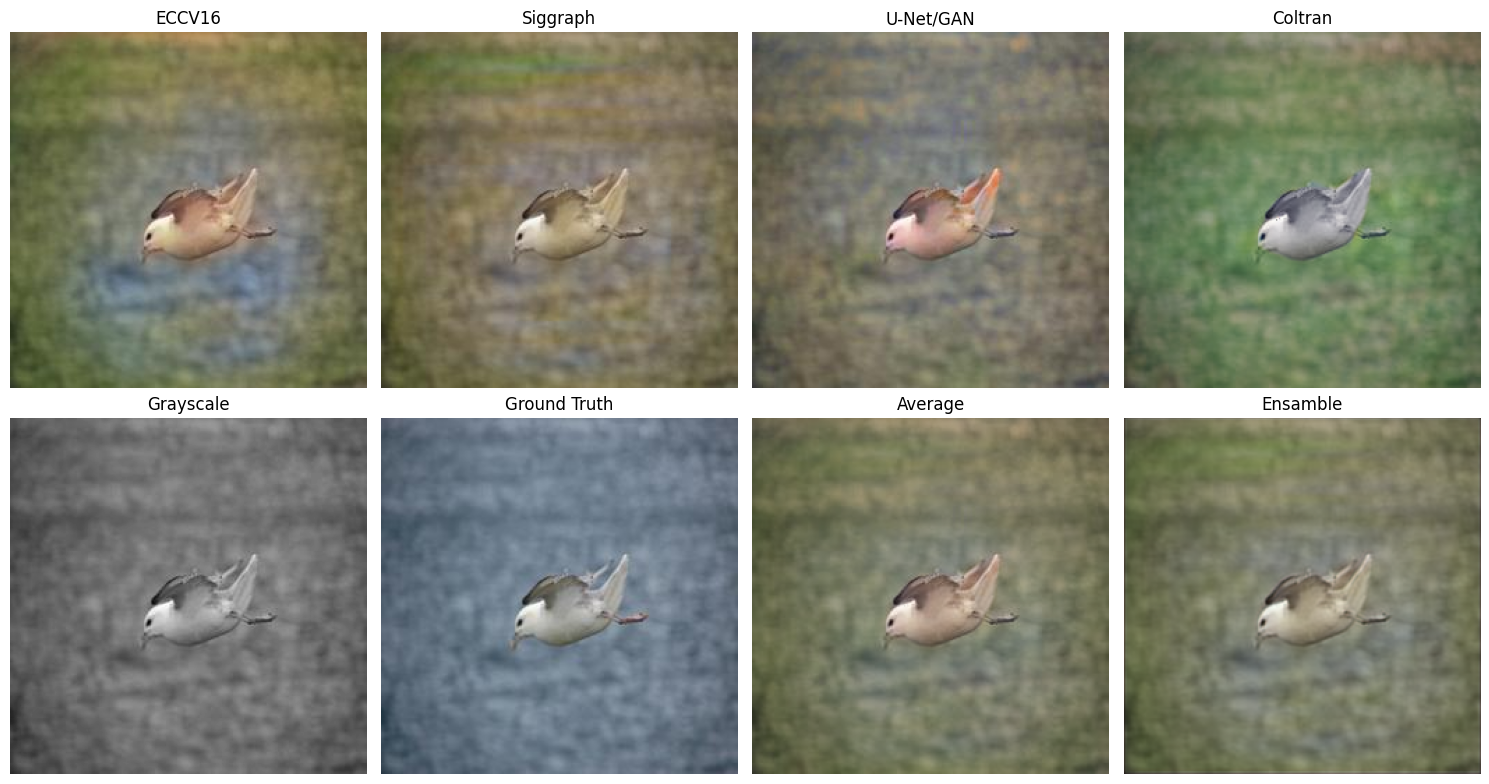

In [33]:
colorize_image(2561, model)

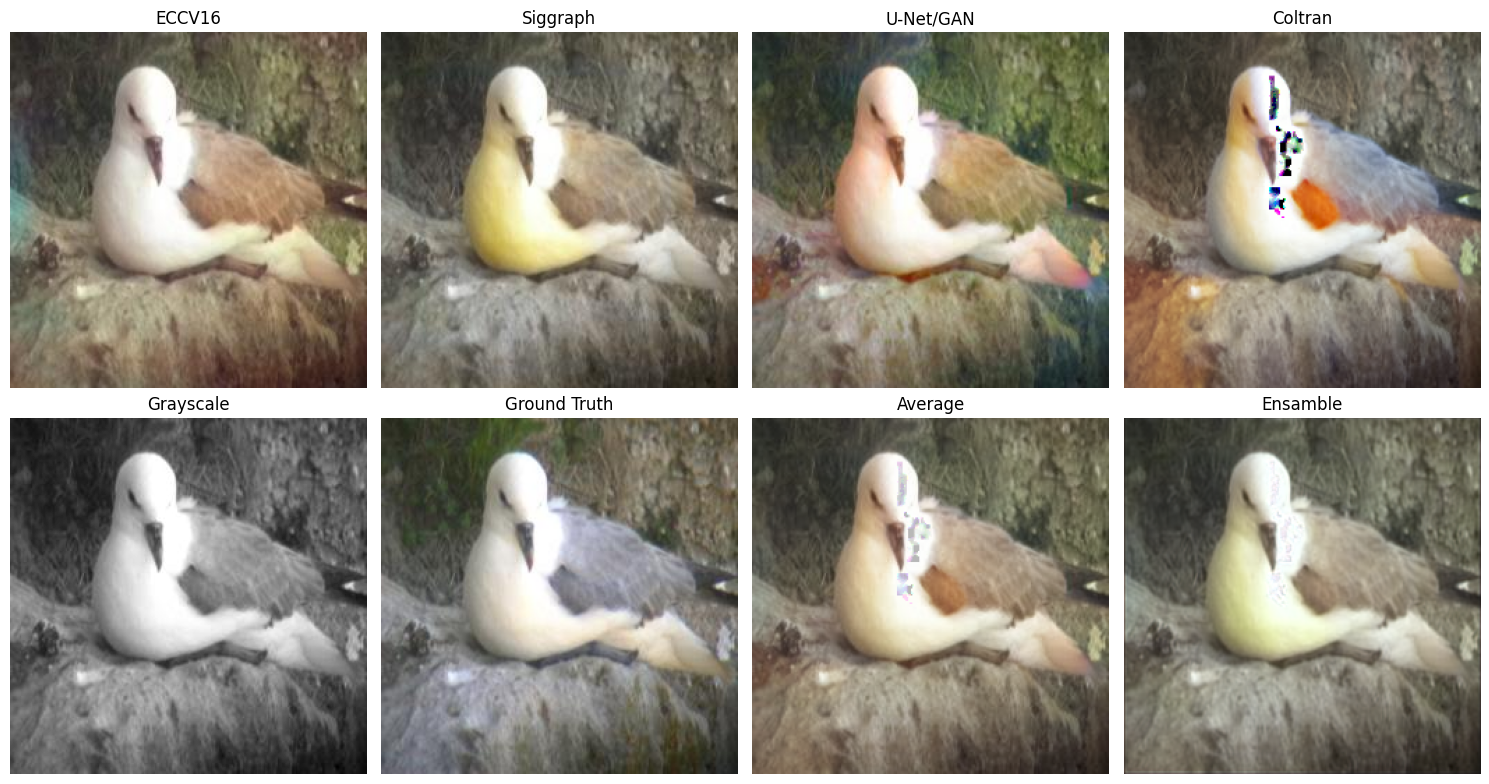

In [36]:
colorize_image(2562, model)

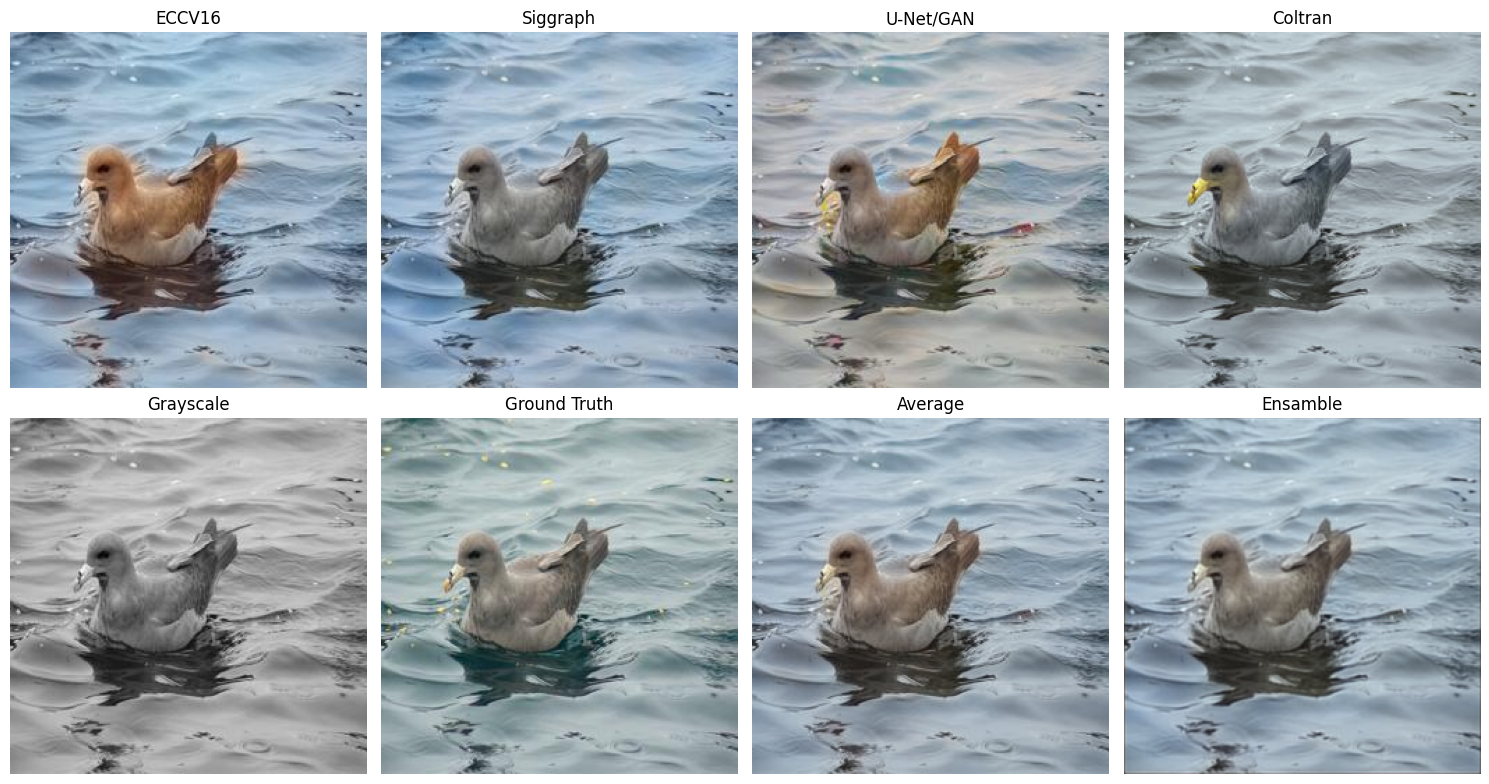

In [35]:
colorize_image(2563, model)

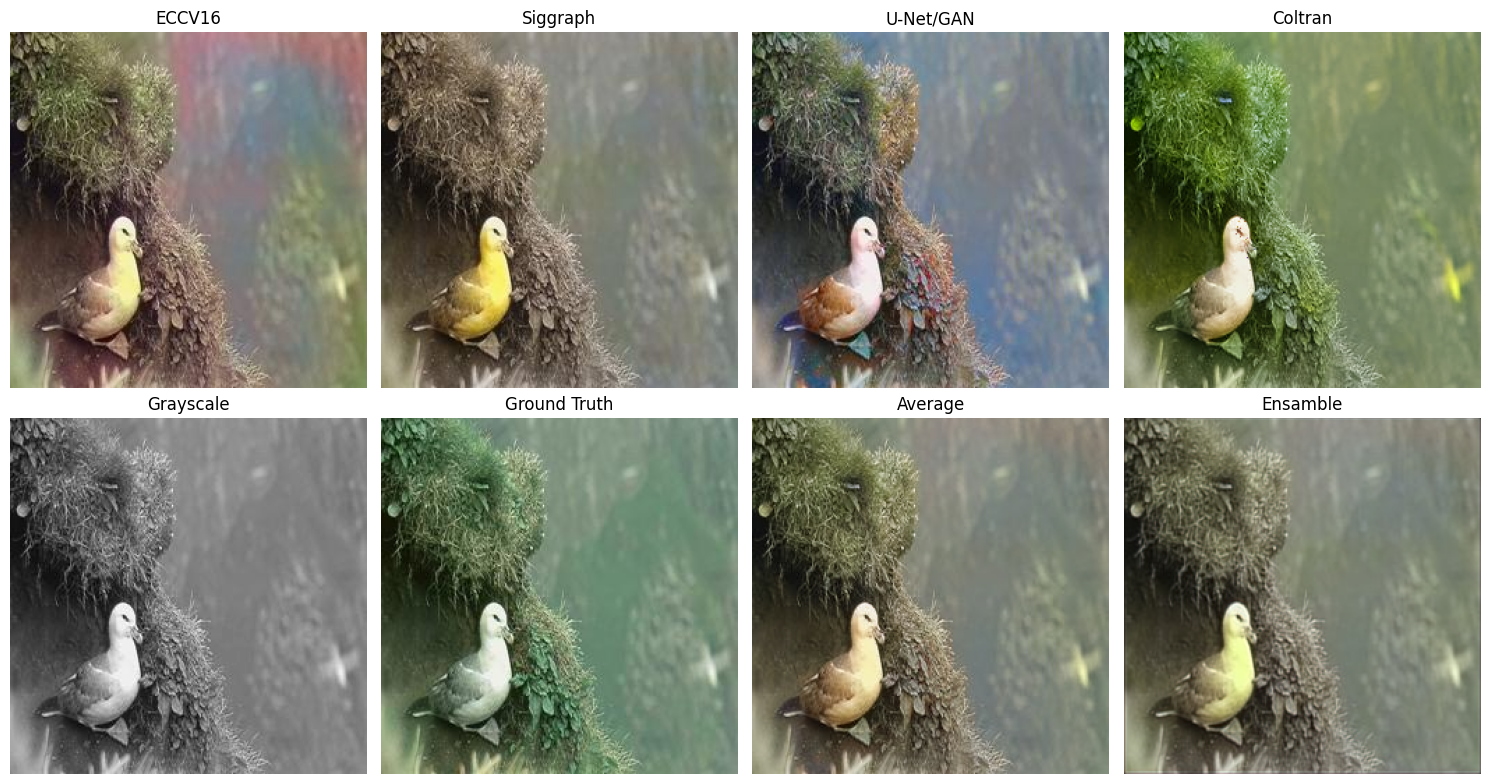

In [34]:
colorize_image(2564, model)